In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl

In [2]:
uk_house_data_all = pd.read_csv(
    'datasets/uk_house_market_data.csv',
    names=[
        'Transaction_unique_identifier',
        'price',
        'date_of_sale',
        'postcode',
        'property_type',
        'old_new',
        'duration',
        'PAON',
        'SAON',
        'street',
        'locality',
        'town_city',
        'district',
        'county',
        'ppd_category_type',
        'record_status',
    ],
    dtype={'price': 'int64'}
)


In [3]:
sales_data_20_years = uk_house_data_all.query('date_of_sale >= "2000-01-01 00:00"')

In [4]:
yearly_data_since_2015 = {}

for year in range(2015, 2024):
    name = f"sales_data_{year}"
    values = sales_data_20_years[sales_data_20_years['date_of_sale'].str.startswith(f'{str(year)}')]
    yearly_data_since_2015[name] = values

In [5]:
yearly_properties_sold = {
    int(key[-4:]) : value['date_of_sale'].count()
    for key, value in yearly_data_since_2015.items()
}

<BarContainer object of 9 artists>

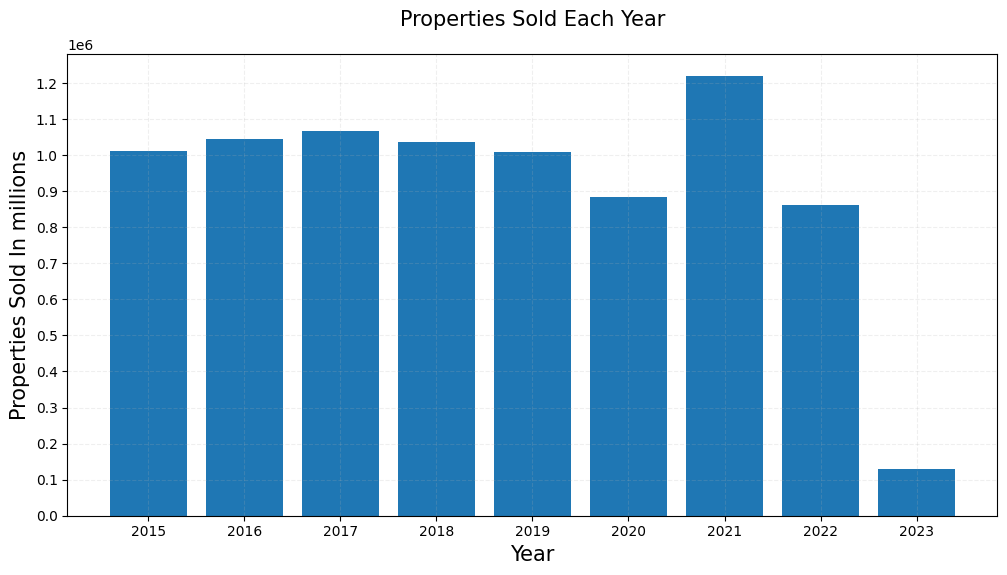

In [6]:
from matplotlib.pyplot import MultipleLocator

fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, alpha=0.2, ls='dashed')
ax.set_title('Properties Sold Each Year', fontsize=15, pad=20)
plt.ylabel('Properties Sold In millions', fontsize=15)
plt.xlabel('Year', fontsize=15)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(100_000))

ax.bar(
    yearly_properties_sold.keys(), yearly_properties_sold.values()
)


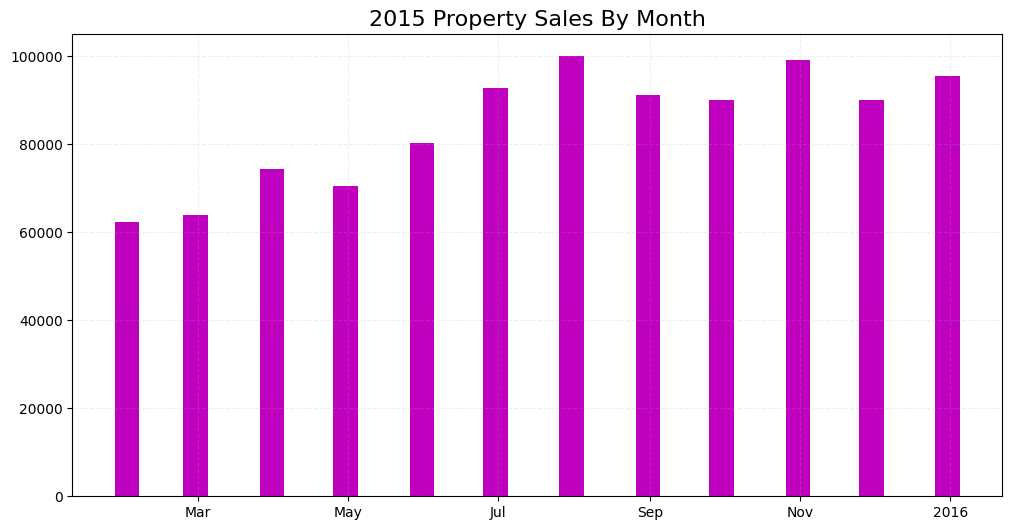

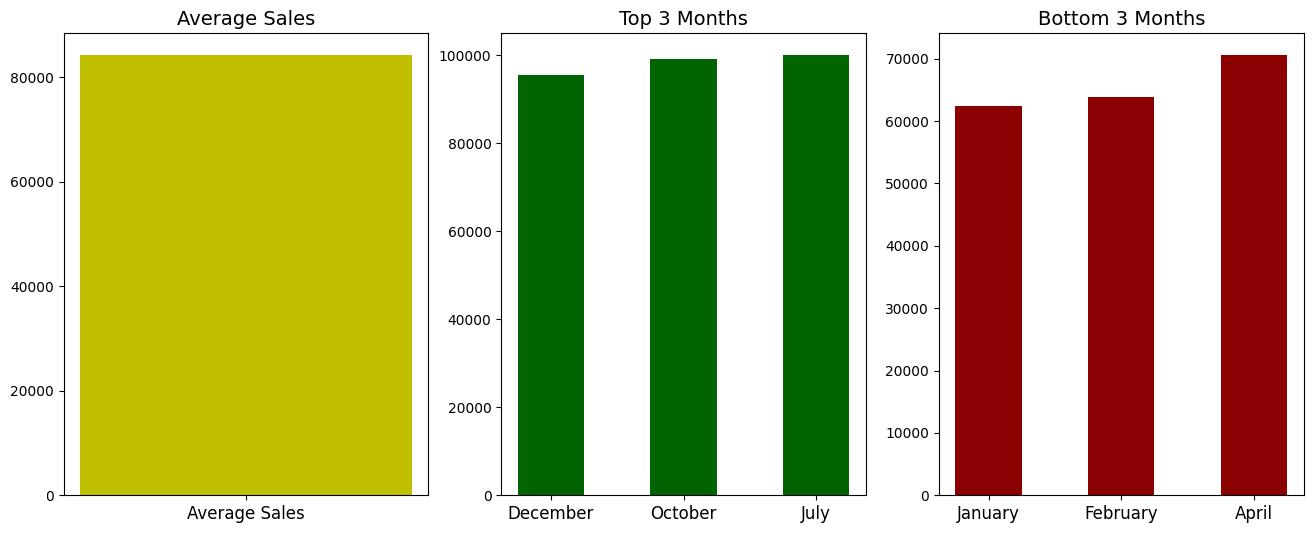

In [38]:
data_for_2015 = yearly_data_since_2015['sales_data_2015'].copy()
data_for_2015['date_of_sale'] = pd.to_datetime(data_for_2015['date_of_sale'])
data_for_2015 = data_for_2015.sort_values('date_of_sale')
monthly_sales_for_2015 = data_for_2015.groupby(pd.Grouper(key='date_of_sale', freq='M')).size().reset_index(name='count')


fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, alpha=0.2, ls='dashed')

cdf = mpl.dates.ConciseDateFormatter(ax.xaxis.get_major_locator())
ax.xaxis.set_major_formatter(cdf)
ax.set_title('2015 Property Sales By Month', fontsize=16)

x = monthly_sales_for_2015['date_of_sale']
y = monthly_sales_for_2015['count']
ax.bar(x, y, color='m', width=10,)

# sorting by sales, giving average, top 3 months and bottom 3 months
monthly_sales_for_2015 = monthly_sales_for_2015.sort_values('count')
average = monthly_sales_for_2015['count'].mean()

# Getting the info for the bottom 3 months and creating a new column to store the month name
bottom_3 = monthly_sales_for_2015.head(3).copy()
bottom_3['month_name'] = bottom_3['date_of_sale'].dt.strftime('%B')

# Getting the info for top 3 months, then creating a new column that stores only the months name
top_3 = monthly_sales_for_2015.tail(3).copy()
top_3['month_name'] = top_3['date_of_sale'].dt.strftime('%B')

fig, ax = plt.subplots(1, 3,figsize=(16, 6))

# Displaying the average sales
ax[0].bar(['Average Sales',], [average], lw=0.5, color='y')
ax[0].set_title('Average Sales', fontsize=14)
ax[0].yaxis.set_major_locator(MultipleLocator(20000))

# Displaying the top 3 months
ax[1].bar(top_3['month_name'], top_3['count'], lw=0.5, width=0.5, align='center', color='darkgreen')
ax[1].set_title('Top 3 Months', fontsize=14)

# Displaying the bottom 3 months
ax[2].bar(bottom_3['month_name'], bottom_3['count'], lw=0.5, width=0.5, align='center', color='darkred')
ax[2].set_title('Bottom 3 Months', fontsize=14)

for axis in ax:
    
    for tick_label in axis.get_xticklabels():
        tick_label.set_fontsize(12)
